# Compsci 571 HW5
## Question 3 Ridge Regression

## 3b) MSE for $\beta_1$ and $\beta_2$ under different $\lambda$ values

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import metrics

In [2]:
X = scipy.io.loadmat('X.mat')
X = X['X'] # take out the real useful matrix (I hate matlab!)

In [3]:
print('Shape of X is:', X.shape)

Shape of X is: (50, 20)


So the X matrix contains 50 observations, and each observation has 20 features.

In [4]:
beta1 = np.array([0.1, 0.3, 0.2, 0.2, 0.9, 0.8, 0.9, 0.1, 0.4, 0.2, 0.7, \
                 0.3, 0.1, 0.7, 0.8, 0.3, 0.2, 0.8, 0.1, 0.7]).reshape(20, 1)
beta2 = np.array([0.5, 0.6, 0.7, 0.9, 0.9, 0.8, 0.9, 0.8, 0.6, 0.5, 0.7, \
                 0.6, 0.7, 0.7, 0.8, 0.8, 0.9, 0.8, 0.5, 0.7]).reshape(20, 1)
print(beta1.shape)
print(beta2.shape)

(20, 1)
(20, 1)


In [49]:
mse_beta1 = []
mse_beta2 = []
for i in np.arange(0.0, 10, 0.1): # outer loop on lambda
    mse1 = 0
    mse2 = 0
    for t in range(100): # inner loop on repetition
        e = np.random.normal(0, 1.0, 50)
        e = e.reshape(50, 1)
        y1 = np.dot(X, beta1) + e
        y2 = np.dot(X, beta2) + e
        ridge = Ridge(alpha = i)
        ridge.fit(X, y1)
        yhat1 = ridge.predict(X)
        mse1 += np.sum((y1 - yhat1) ** 2)
        ridge.fit(X, y2)
        yhat2 = ridge.predict(X)
        mse2 += np.sum((y2 - yhat2) ** 2)
    mse1 = mse1 / 100
    mse2 = mse2 / 100
    mse_beta1.append(mse1)
    mse_beta2.append(mse2)

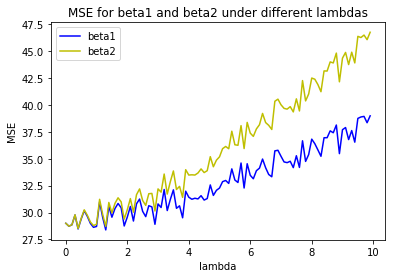

In [50]:
plt.plot(np.arange(0.0, 10, 0.1), mse_beta1, c = 'b', label = 'beta1')
plt.plot(np.arange(0.0, 10, 0.1), mse_beta2, c = 'y', label = 'beta2')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('MSE for beta1 and beta2 under different lambdas')
plt.show()

## 3c) singular value decomposition

Center and standardize X on rows such that $X^T X = n * corr{(X)}$.

In [28]:
from sklearn import preprocessing

In [48]:
X_trans = preprocessing.scale(X, axis = 0) # standardize each columns

In [35]:
print(X_trans.shape)
print(X_trans.mean(axis = 0)) # mean for each column
print(X_trans.std(axis = 0)) # standard deviation for each column
print(np.dot(X_trans.T, X_trans)[0,0])
print(np.corrcoef(X_trans, rowvar=False)[0,0])

(50, 20)
[ 4.44089210e-18  4.44089210e-17 -1.99840144e-17 -1.99840144e-17
 -2.10942375e-17 -5.55111512e-18  2.22044605e-17 -9.43689571e-18
  4.39925874e-17  4.44089210e-18  4.44089210e-18  8.88178420e-18
  2.77555756e-18  2.22044605e-18 -1.55431223e-17 -4.44089210e-18
 -1.77635684e-17 -1.77635684e-17  1.44328993e-17 -8.88178420e-18]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
50.0
0.9999999999999998


Singular value decomposition of X

In [36]:
# np.dot(np.dot(u, np.diag(s)), vh) = X_trans
u, s, vh = np.linalg.svd(X_trans, full_matrices=False)

In [37]:
print(u.shape)
print(s.shape)
print(s)
print(vh.shape)

(50, 20)
(20,)
[10.82452831  9.72481351  9.39715469  8.7879914   8.66989598  8.21331949
  7.9101386   7.6012111   7.45809936  7.1168226   6.76081749  6.44731429
  6.02919276  5.48157964  5.12696913  4.50626637  4.29171197  3.97481767
  3.35954521  2.77548158]
(20, 20)


$\hat{\gamma}^{ridge} = \mathbf{V}^{T} \hat{\beta}^{ridge} = (\mathbf{L}^2 + \lambda \mathbf{I}_{p})^{-1} \mathbf{L} \mathbf{U}^{T}_{p} \mathbf{Y}.$

In [38]:
def predict_gamma(X, y, lambda_value):
    # u.shape = [50, 20]
    # s.shape = [20, ] just a vector, not the diagonal matrix
    # vh.shape = [20, 20]
    u, s, vh = np.linalg.svd(X_trans, full_matrices=False)
    gamma_hat = np.diag(s / (s ** 2 + lambda_value))
    gamma_hat = np.dot(gamma_hat, u.T)
    gamma_hat = np.dot(gamma_hat, y)
    return gamma_hat

In [39]:
def generate_y_intercept(X, alpha, beta):
    assert X.shape[1] == beta.shape[0]
    n = X.shape[0]
    p = X.shape[1]
    e = np.random.normal(0, 1.0, n)
    e = e.reshape(n, 1)
    y = alpha + np.dot(X, beta) + e
    return y

In [40]:
def ridge_svd(X, alpha, beta, lambda_value, t = 100):
#     mean_gamma_hat = np.zeros([20, 1])
    gamma_hats = np.empty([20, 0])
    for i in range(t):
        y = generate_y_intercept(X, alpha, beta)
        gamma_hat = predict_gamma(X, y, lambda_value)
#         mean_gamma_hat += gamma_hat
        gamma_hats = np.append(gamma_hats, gamma_hat, axis=1)
#     mean_gamma_hat /= t
#     return mean_gamma_hat
    return gamma_hats

In [41]:
# mean_gamma_hat = ridge_svd(X_trans, 0.1, beta1, 1)
gamma_hats = ridge_svd(X_trans, 0.1, beta1, 1)
mean_gamma_hat = np.mean(gamma_hats, axis=1)

$\gamma = \mathbf{V}^{T} \beta$

In [42]:
u, s, vh = np.linalg.svd(X_trans, full_matrices=False)
gamma = np.dot(vh, beta1)

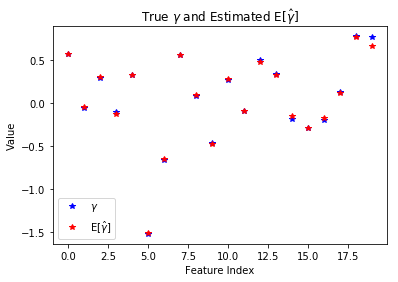

In [46]:
plt.plot(range(0, 20), gamma, '*', color='blue', label=r'$\gamma$')
plt.plot(range(0, 20), mean_gamma_hat, '*', color='red', label=r'E[$\hat{\gamma}$]')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.title(r'True $\gamma$ and Estimated E[$\hat{\gamma}$]')
plt.legend()
plt.show()

In [44]:
v1 = np.zeros([20, 1])
v2 = np.zeros([20, 1])
for i in range(20):
    v1[i, 0] = np.mean((gamma_hats[i, :] - gamma[i, 0]) ** 2)
    v2[i, 0] = (s[i] ** 2 + gamma[i, 0] ** 2) / (s[i] ** 2 + 1) ** 2

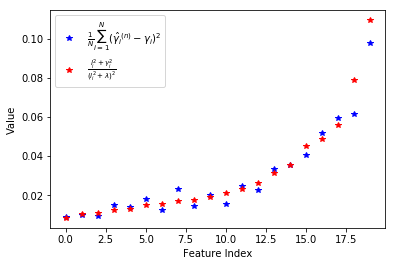

In [47]:
plt.plot(range(0, 20), v1, '*', color='blue', \
         label=r'$\frac{1}{N}\sum_{i=1}^{N}(\hat{\gamma_i}^{(n)} - \gamma_i)^2$')
plt.plot(range(0, 20), v2, '*', color='red', \
        label=r'$\frac{l_i^2 + \gamma_i^2}{(l_i^2 + \lambda)^2}$')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()